In [1]:
import pandas as pd

start_year = 1988
end_year = 2010

year_labels = []
for y in range(start_year, end_year + 1):
    next_yy = str(y + 1)[:2]
    label = f"{y}/{next_yy}"
    year_labels.append(label)

print(year_labels)

subtables = []

first_skip = 4 # Based on 0 indexing, (row 5 in excels 1 indexing)
row_spacing = 13 # Difference in Excel rows between tables
nrows_per_subtable = 8 # Number of rows per subtable

for i, year_label in enumerate(year_labels):
    # Calculate the zero-based 'skiprows' for this subtable
    skip = first_skip + i * row_spacing
    # Build the (year_label, skiprows, nrows) tuple
    subtables.append((year_label, skip, nrows_per_subtable))

print(subtables)

file_path = "Jamtalferner.xlsx"
sheet_name = "elevation zones"

df_list = []

for (year_label, skip, nrows) in subtables:
    df_year = pd.read_excel(
        file_path,
        sheet_name=sheet_name,
        skiprows=skip,        # zero-based row index
        nrows=nrows,          # read exactly 8 rows
        header=None           # no header => read raw data
    )
    
    # Keep only the first 6 columns
    df_year = df_year.iloc[:, :6]  # columns 0 through 5

    # Assign your own column names here:
    df_year.columns = [
        "altitude_zone_m", "SaZ_km2", "BaZ_10^3_m3", 
        "baZ_kg/m2", "bsaZ_kg/m2", "bwaZ_kg/m2"
    ]

    # Tag each DataFrame chunk with the year
    df_year["Year"] = year_label
    
    df_list.append(df_year)

# Combine them all
combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.head(30))


['1988/19', '1989/19', '1990/19', '1991/19', '1992/19', '1993/19', '1994/19', '1995/19', '1996/19', '1997/19', '1998/19', '1999/20', '2000/20', '2001/20', '2002/20', '2003/20', '2004/20', '2005/20', '2006/20', '2007/20', '2008/20', '2009/20', '2010/20']
[('1988/19', 4, 8), ('1989/19', 17, 8), ('1990/19', 30, 8), ('1991/19', 43, 8), ('1992/19', 56, 8), ('1993/19', 69, 8), ('1994/19', 82, 8), ('1995/19', 95, 8), ('1996/19', 108, 8), ('1997/19', 121, 8), ('1998/19', 134, 8), ('1999/20', 147, 8), ('2000/20', 160, 8), ('2001/20', 173, 8), ('2002/20', 186, 8), ('2003/20', 199, 8), ('2004/20', 212, 8), ('2005/20', 225, 8), ('2006/20', 238, 8), ('2007/20', 251, 8), ('2008/20', 264, 8), ('2009/20', 277, 8), ('2010/20', 290, 8)]
   altitude_zone_m SaZ_km2 BaZ_10^3_m3 baZ_kg/m2 bsaZ_kg/m2 bwaZ_kg/m2  \
0        3100-3200       *           *         *          *          *   
1        3000-3100    0.21          46       220       -860       1080   
2        2900-3000   0.854         204       240 

In [2]:
combined_df["Year"] = combined_df["Year"].str.split("/").str[0]  # keep '1988' from '1988/89'
combined_df["Year"] = pd.to_datetime(
    combined_df["Year"], 
    format="%Y"
)

def range_to_midpoint(range_str):
    """
    Convert a string like '3100-3200' to the midpoint (e.g. 3150.0).
    If parsing fails, return None (which becomes NaN).
    """
    if isinstance(range_str, str) and '-' in range_str:
        low_str, high_str = range_str.split('-')
        try:
            low = float(low_str)
            high = float(high_str)
            return (low + high) / 2
        except ValueError:
            # If it can't convert to float, return None
            return None
    else:
        # No dash or not a string => not a range => treat as missing or handle differently
        return None

# Apply the function to each row in altitude_zone_m
combined_df['altitude_zone_m'] = combined_df['altitude_zone_m'].apply(range_to_midpoint)

# Columns to convert:
cols_to_convert = [
    "SaZ_km2", 
    "BaZ_10^3_m3", 
    "baZ_kg/m2", 
    "bsaZ_kg/m2", 
    "bwaZ_kg/m2"
]

# Convert each to numeric with coercion:
for col in cols_to_convert:
    combined_df[col] = pd.to_numeric(combined_df[col], errors="coerce")

# Then, if you want to drop any rows that have NaN in any of those columns:
combined_df.dropna(subset=cols_to_convert, inplace=True)

print(combined_df.dtypes)

print(combined_df.head(30))

altitude_zone_m           float64
SaZ_km2                   float64
BaZ_10^3_m3               float64
baZ_kg/m2                 float64
bsaZ_kg/m2                float64
bwaZ_kg/m2                float64
Year               datetime64[ns]
dtype: object
    altitude_zone_m  SaZ_km2  BaZ_10^3_m3  baZ_kg/m2  bsaZ_kg/m2  bwaZ_kg/m2  \
1            3050.0    0.210         46.0      220.0      -860.0      1080.0   
2            2950.0    0.854        204.0      240.0      -890.0      1130.0   
3            2850.0    0.798        -45.0      -60.0     -1090.0      1030.0   
4            2750.0    0.854       -268.0     -310.0     -1390.0      1080.0   
5            2650.0    0.668       -562.0     -840.0     -1850.0      1010.0   
6            2550.0    0.344       -674.0    -1960.0     -2930.0       970.0   
7            2450.0    0.125       -393.0    -3140.0     -4090.0       950.0   
9            3050.0    0.210         25.0      120.0       890.0      -770.0   
10           2950.0    0.854

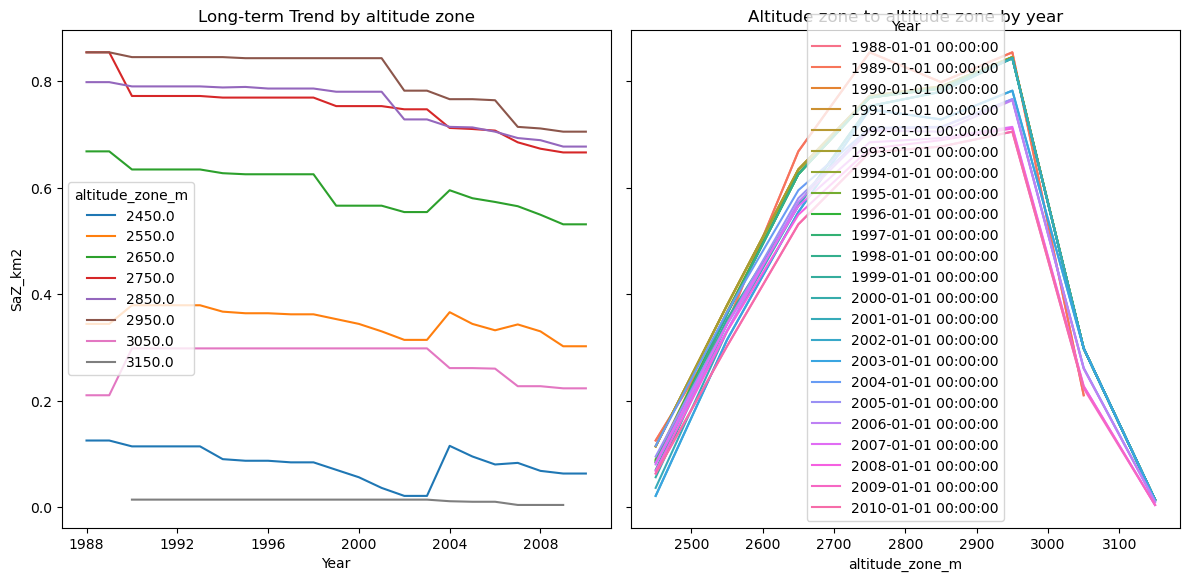

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax0, ax1 = axes

# 1) Long-term trend, colored by month
sns.lineplot(
    data=combined_df,
    x='Year',
    y='SaZ_km2',
    hue='altitude_zone_m',
    ax=ax0,
    palette='tab10'
)
ax0.set_title("Long-term Trend by altitude zone")

# 2) Month-by-month trend, colored by year
sns.lineplot(
    data=combined_df,
    x='altitude_zone_m',
    y='SaZ_km2',
    hue='Year',
    ax=ax1,
    palette='husl'
)
ax1.set_title("Altitude zone to altitude zone by year")

plt.tight_layout()
plt.show()

<>:27: SyntaxWarning: invalid escape sequence '\,'
<>:27: SyntaxWarning: invalid escape sequence '\,'
/var/folders/bn/slxdtr295gqf898qvsy9rsc00000gn/T/ipykernel_32394/107106213.py:27: SyntaxWarning: invalid escape sequence '\,'
  "BaZ / $10^3 \, m^3$",


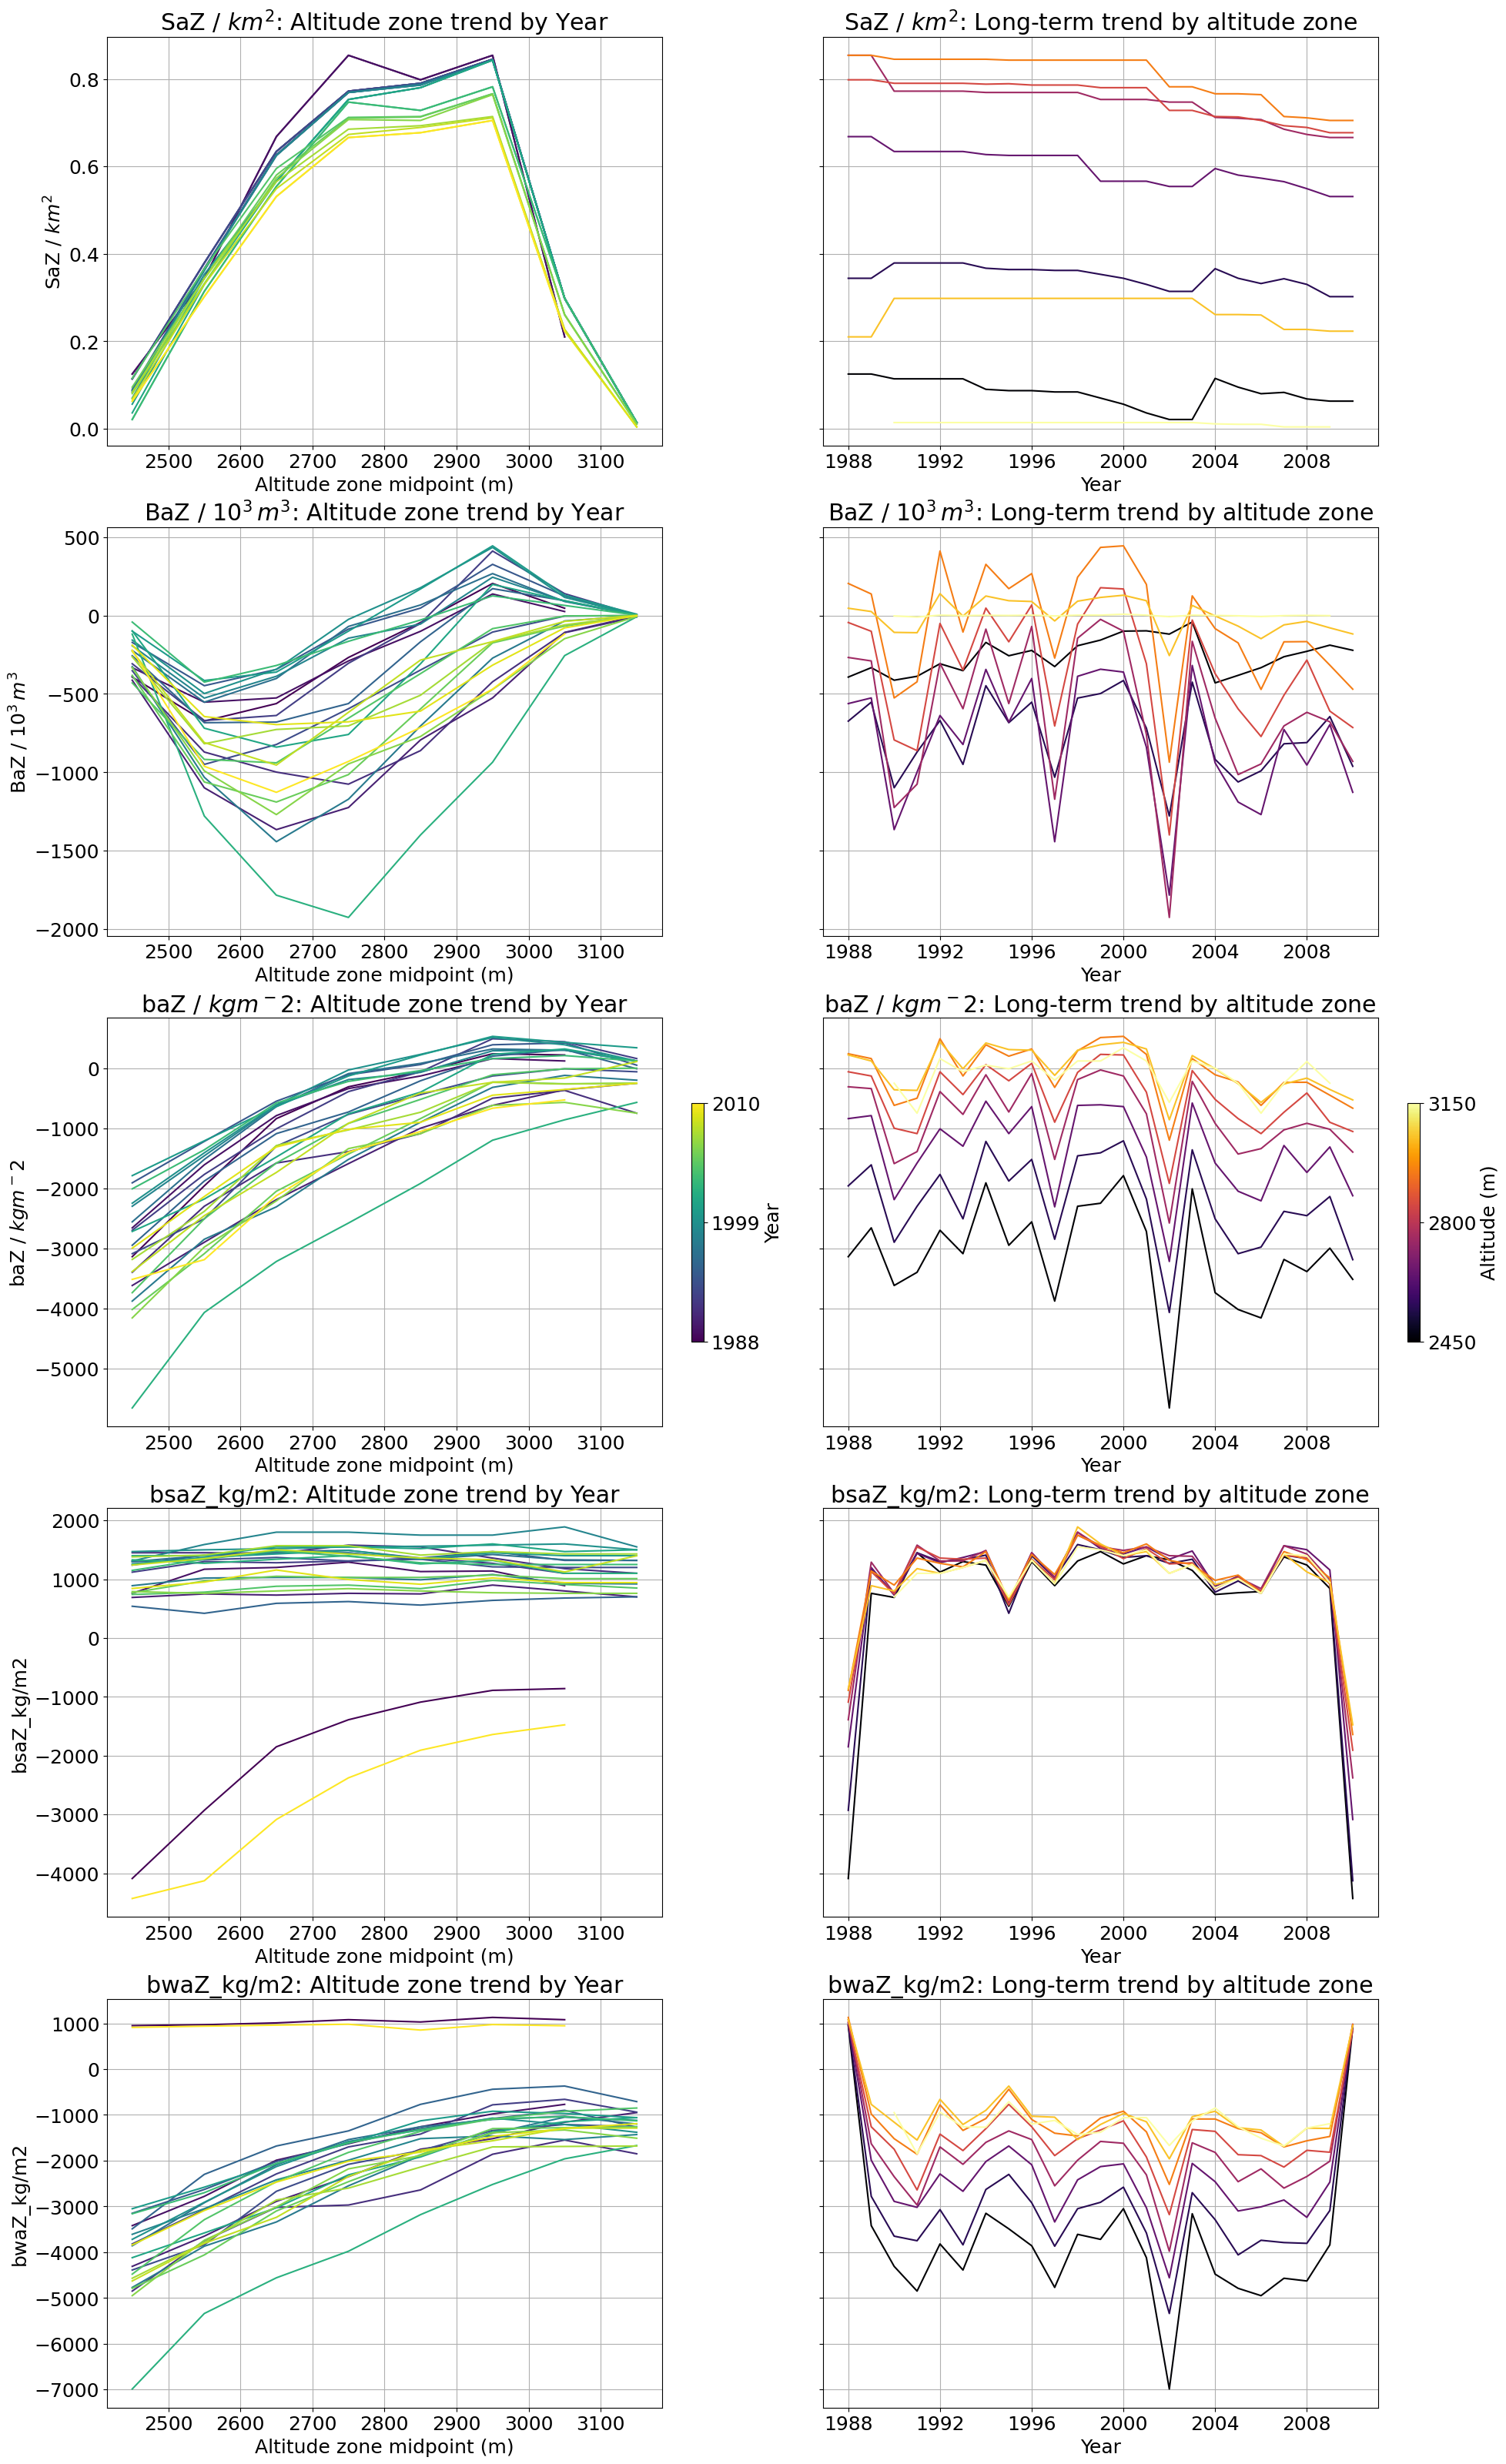

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['font.size'] = 18  # This sets the base font size for all text

combined_df['year_numeric'] = combined_df['Year'].dt.year

alt_min = combined_df["altitude_zone_m"].min()
alt_max = combined_df["altitude_zone_m"].max()

year_min = combined_df["Year"].dt.year.min()
year_max = combined_df["Year"].dt.year.max()

alt_norm  = mcolors.Normalize(vmin=alt_min, vmax=alt_max)
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)

combined_df[r'BaZ / $10^3 \, m^3$'] = combined_df['BaZ_10^3_m3']
combined_df[r'baZ / $kgm^-2$'] = combined_df['baZ_kg/m2']
combined_df[r'SaZ / $km^2$'] = combined_df['SaZ_km2']

# List your variables of interest
variables = [
    "SaZ / $km^2$", 
    "BaZ / $10^3 \, m^3$", 
    "baZ / $kgm^-2$", 
    "bsaZ_kg/m2", 
    "bwaZ_kg/m2"
]

# Create a figure and axes grid: 5 rows, 2 columns
fig, axes = plt.subplots(nrows=5, ncols=2, 
                         figsize=(22, 40),  # Adjust as needed
                         sharey='row')     # Each row shares a y-axis

# Flatten axes for easier indexing if you like
# but in this case, we'll address them as axes[row, col].
for i, var in enumerate(variables):
    ax_left  = axes[i, 1]
    ax_right = axes[i, 0]
    
    # LEFT PLOT: Year vs. var, colored by altitude
    sns.lineplot(
        data=combined_df,
        x='Year',
        y=var,
        hue='altitude_zone_m',
        hue_norm=alt_norm,
        palette='inferno',
        legend=False,
        ax=ax_left
    )
    ax_left.set_title(f"{var}: Long-term trend by altitude zone")
    ax_left.set_xlabel("Year") 
    ax_left.set_ylabel(var)
    ax_left.grid(True)

    # RIGHT PLOT: Altitude vs. var, colored by Year
    sns.lineplot(
        data=combined_df,
        x='altitude_zone_m',
        y=var,
        hue='year_numeric',
        hue_norm=year_norm,
        palette='viridis',
        legend=False,
        ax=ax_right
    )
    ax_right.set_title(f"{var}: Altitude zone trend by Year")
    ax_right.set_xlabel("Altitude zone midpoint (m)")
    ax_right.set_ylabel(var)
    ax_right.grid(True)

# Color bar for altitude (goes with left column)
# The ‘ax=axes[:,0]’ means it will attach to all rows of the first column.
alt_sm = ScalarMappable(norm=alt_norm, cmap='inferno')
alt_sm.set_array([])            # Requried dummy for colourbar
cbar_alt = fig.colorbar(
    alt_sm,
    ax=axes[:, 1],              # Attach to all subplots in the left column
    orientation="vertical",
    fraction=0.02,              # Shrink the colourbar
    pad=0.05                     # Spacing between subplot and colourbar
)
cbar_alt.set_label("Altitude (m)")

# Optionally specify ticks for min, mid, max altitude:
cbar_alt.set_ticks([alt_min, (alt_min + alt_max)/2, alt_max])
cbar_alt.set_ticklabels([
    f"{int(alt_min)}",
    f"{int((alt_min + alt_max)/2)}",
    f"{int(alt_max)}"
])

# Color bar for year (goes with right column)
year_sm = ScalarMappable(norm=year_norm, cmap='viridis')
year_sm.set_array([])
cbar_year = fig.colorbar(
    year_sm, 
    ax=axes[:, 0],     
    orientation="vertical",
    fraction=0.02,
    pad=0.05
)
cbar_year.set_label("Year")

# Likewise, show min, mid, and max year
cbar_year.set_ticks([year_min, (year_min + year_max)/2, year_max])
cbar_year.set_ticklabels([
    str(int(year_min)),
    str(int((year_min + year_max)/2)),
    str(int(year_max))
])

plt.savefig("jamtalferner_elevation", dpi=500)

plt.show()
